In [1]:
import yaml
import itertools
import numpy as np
import matplotlib.pyplot as plt


raw_data = yaml.safe_load(open("./rawdata.yaml", "r"))

board_keys = ['MSP430FR5994', 'MSP430FR5969', 'MSP430FR2433']
frequency_keys = ['1MHZ', '2MHZ', '4MHZ']
system_keys = ['idle', 'testbench']
adc_keys = ['ADC_off', 'ADC_on']
interval_keys = ['100us', '150us', '200us', '250us', '300us', '400us', '500us', '600us', '800us', '1000us']

将原始数据中每个条件下的平均电流提取出来，计算ADC带来的额外的电流值大小并输出。

In [2]:
# Take the average value of the current in each case and calculate the amount of additional current brought by the ADC based on it.

current_vector = []

for board in board_keys:
    for frequ, system in itertools.product(frequency_keys, system_keys):
        case_data = raw_data[board][frequ][system]
        adc_off_current = case_data['ADC_off'][0]   # mean value as index 0
        adc_on_current = np.array([case_data['ADC_on'][int_key][0] for int_key in interval_keys])
        adc_extra_current = adc_on_current - adc_off_current
        print("{}, {}, {:10}, extra current: {}".format(board, frequ, system, adc_extra_current))
        current_vector.append(adc_extra_current)
    print()


MSP430FR5994, 1MHZ, idle      , extra current: [0.1996 0.1242 0.094  0.0758 0.0646 0.0494 0.0399 0.0339 0.0262 0.0218]
MSP430FR5994, 1MHZ, testbench , extra current: [0.182  0.1239 0.0942 0.0762 0.0639 0.0488 0.0394 0.0334 0.0263 0.0215]
MSP430FR5994, 2MHZ, idle      , extra current: [0.1875 0.1304 0.1014 0.0839 0.0722 0.0573 0.0486 0.0426 0.0354 0.0309]
MSP430FR5994, 2MHZ, testbench , extra current: [0.1795 0.1223 0.0948 0.0767 0.0645 0.0513 0.0418 0.0358 0.0285 0.0248]
MSP430FR5994, 4MHZ, idle      , extra current: [0.1826 0.1259 0.0964 0.0793 0.0675 0.0529 0.0439 0.0383 0.0345 0.0301]
MSP430FR5994, 4MHZ, testbench , extra current: [0.1739 0.1165 0.0889 0.0728 0.0606 0.0461 0.0366 0.0314 0.0237 0.0193]

MSP430FR5969, 1MHZ, idle      , extra current: [0.1819 0.1214 0.0921 0.0741 0.0693 0.0546 0.045  0.0389 0.0312 0.0266]
MSP430FR5969, 1MHZ, testbench , extra current: [0.1843 0.1233 0.094  0.0759 0.0623 0.0476 0.0396 0.0336 0.0253 0.0212]
MSP430FR5969, 2MHZ, idle      , extra current: 

从上面的输出可以看出来，如果我们将误差允许的范围扩到一个比较大的值，ADC带来的额外的电流消耗与开发板本身的能耗（例如频率、是否运行testbench等）关系不大（**这也是符合我们的预期的：频率、是否运行testbench等和ADC是独立的**），**其与ADC的类型（例如FR5994和FR5969是12-bit的ADC，而FR2433是10-bit的ADC）以及ADC的sample frequency有关系**。

因此，我们将开发板的类型（即ADC的类型）与sample frequency作为变量，将属于同一类的值求平均。

In [3]:
intervals =  1e-6 * np.array([100, 150, 200, 250, 300, 400, 500, 600, 800, 1000]) # standard unit in (s)
frequencys = np.power(intervals, -1)

fr5994_extra_current = 1e-3 * (sum(current_vector[ 0:  6]) / 6)    # standard unit in (A)
fr5969_extra_current = 1e-3 * (sum(current_vector[ 6: 12]) / 6)
fr2433_extra_current = 1e-3 * (sum(current_vector[12: 18]) / 6)

绘制`extra current`与`frequencys`（即每秒ADC采样的次数）之间的关系。

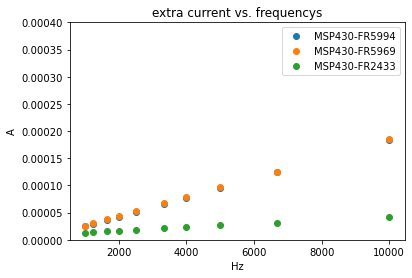

In [4]:
plt.plot(frequencys, fr5994_extra_current, 'o', label="MSP430-FR5994")
plt.plot(frequencys, fr5969_extra_current, 'o', label="MSP430-FR5969")
plt.plot(frequencys, fr2433_extra_current, 'o', label="MSP430-FR2433")

plt.title("extra current vs. frequencys")
plt.ylim(0, 4e-4)
plt.ylabel("A")
plt.xlabel("Hz")
plt.legend()

plt.show()

可以看到这些点很好地满足了线性增长的趋势，并且FR5994和FR5969的ADC能耗几乎完全相同，并且都远高于FR2433。这整体符合预期，即：

- 10-bit的ADC更加节能；
- ADC的能耗与开发板没有直接的关系。

尝试使用最小二乘法进行线性回归。

In [5]:
def regression(x,y):
    n = len(x)
    X = sum(x)
    Y = sum(y)

    A = sum([xi**2 for xi in x])
    C = sum([xi*yi for xi, yi in zip(x,y)])

    D = X**2 - n*A
    m = (X*Y - n*C) / float(D)
    b = (C*X - A*Y) / float(D)

    return (m, b)

fr5994_regression_param = regression(frequencys, fr5994_extra_current)
fr5969_regression_param = regression(frequencys, fr5969_extra_current)
fr2433_regression_param = regression(frequencys, fr2433_extra_current)

print(fr5994_regression_param)
print(fr5969_regression_param)
print(fr2433_regression_param)

(1.7700283956915548e-08, 6.611437527874333e-06)
(1.7692658510525652e-08, 8.004969406449814e-06)
(3.1641174715321152e-09, 1.010259379401734e-05)


即我们得到了自变量`frequency`（用$N_{\text{ps}}$）和因变量`extra current`（用$I_{\text{extra}}$）的关系如下。

$$
\text{For MSP430FR5994: } I_{\text{extra}} = (1.77 N_{\text{ps}} + 661) \times 10^{-8} \\ 
\text{For MSP430FR5969: } I_{\text{extra}} = (1.77 N_{\text{ps}} + 800) \times 10^{-8} \\ 
\text{For MSP430FR2433: } I_{\text{extra}} = (0.316 N_{\text{ps}} + 1010) \times 10^{-8} \\ 
$$


另外从这个结果还能看出一些问题：**对于FR2433来说，其基础能耗高（即截距），但每秒额外进行一次ADC采样带来的电流大小低（即斜率）。这说明FR2433的基础能耗高，低功耗不好，但因为只有10-bit ADC，所以当采样次数足够多时，能耗低于FR5994和FR2433**。

将线性回归的结果同上面的散点图结合，得到下图。

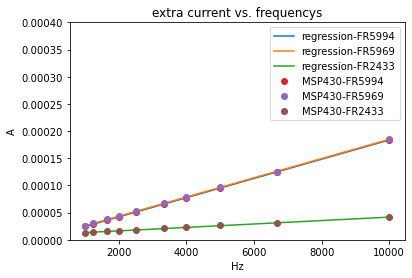

In [6]:
x_ticks = np.arange(frequencys.min(), frequencys.max(), 1)

m, b = fr5994_regression_param
y_fr5994_ticks = x_ticks * m + b
plt.plot(x_ticks, y_fr5994_ticks, label="regression-FR5994")

m, b = fr5969_regression_param
y_fr5969_ticks = x_ticks * m + b
plt.plot(x_ticks, y_fr5969_ticks, label="regression-FR5969")

m, b = fr2433_regression_param
y_fr2433_ticks = x_ticks * m + b
plt.plot(x_ticks, y_fr2433_ticks, label="regression-FR2433")

plt.plot(frequencys, fr5994_extra_current, 'o', label="MSP430-FR5994")
plt.plot(frequencys, fr5969_extra_current, 'o', label="MSP430-FR5969")
plt.plot(frequencys, fr2433_extra_current, 'o', label="MSP430-FR2433")

plt.title("extra current vs. frequencys")
plt.ylim(0, 4e-4)
plt.ylabel("A")
plt.xlabel("Hz")
plt.legend()

plt.show()

可以看到拟合地非常精确。